In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import fsolve
from numpy import linalg as LA

/Users/alynmusselman/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class FiniteDifference():
    """
        Finite Difference Method for Poisson equation Lu=RHS, u(D)=bc, where L is the Laplacian Operator and D is the boundary.

        Class: FinitieDIfference
        Attributes: 
            GridDomainx, GridDomainy: x1, y1 that define the rectangular grid to analyze
            GridSpacing: Parameter to specify the spacing of the 2D grid
            BoundaryFunction: function with [x,y] as input and z as output
            RHS: represents f, function with [x,y] as input and z as output

    """

    def __init__(self, GridDomainx: [int, int], GridDomainy: [int, int], GridSpacing):
        self.GridDomainx = GridDomainx
        self.GridDomainy = GridDomainy
        self.GridSpacing = GridSpacing
        self.BoundaryFunction = 0
        self.RHS = 0
        self.Grid = 0
        self.Boundaries = 0
        self.RHSGrid = 0
        self.SystemGrid = 0
        self.Solution = 0



    def discretize_system(self):
        """
            build grid from GridDomain_ and GridSpacing and store in self.Grid
        """
        nx, ny = int((self.GridDomainx[1]-self.GridDomainx[0]) / self.GridSpacing +1), int((self.GridDomainy[1]-self.GridDomainy[0]) / self.GridSpacing + 1)
        x = np.linspace(self.GridDomainx[0], self.GridDomainx[1], nx)
        y = np.linspace(self.GridDomainy[0], self.GridDomainy[1], ny)
        self.Grid = np.meshgrid(x,y)


    def evaluate_rhs(self):
        """
            Evaluate the RHS on the grid points
        """
        self.RHSGrid = self.RHS([self.Grid[0],self.Grid[1]])  


    def evalualte_boundary(self):
        """
            Evaluate the bc on the grid points
        """
        self.Boundaries = self.BoundaryFunction([self.Grid[0],self.Grid[1]])


    def evaluate_grid(self):
        """
            Put the inner and outer grids together in systemgrid
        """
        # build the grid
        self.discretize_system()
        self.evalualte_boundary()
        self.evaluate_rhs()

        self.SystemGrid = self.RHSGrid


    def add_boundary(self):
        """
            add the boundary conditions to get the final solution
            I DON'T KNOW WHY MY SOLUTION IS NEGATIVE BUT IT IS SO I HAVE TO SUBTRACT IT
        """
        self.Solution = -self.Solution + self.Boundaries
        self.RHSGrid = self.RHSGrid + self.Boundaries


    def solve(self):
        """ 
            Given Laplacian(u)-f, find u such that Laplacian(u)-f = 0
        """
        # get f and g evaluated on the grid
        self.evaluate_grid()

        # make a random initial guess for the inner points
        nx, ny = np.shape(self.SystemGrid[1:-1,1:-1])[0], np.shape(self.SystemGrid[1:-1,1:-1])[1]
        initial_guess = np.random.rand(nx,ny).flatten()

        # solve the inner grid
        s = fsolve(self.errf, initial_guess, full_output=1)

        print("Number of iterations to solve: " + str(s[1]['nfev']))

        # show errmsg if any
        if s[2]!=1:
            print(s[3])

        # save the solution
        self.Solution = np.zeros(np.shape(self.SystemGrid))
        self.Solution[1:-1,1:-1] = s[0].reshape(nx,ny)

        # add the boundary conditions to get the final solution
        self.add_boundary()


    def errf(self, approx):
        """
            L(u_inner) - F = err
        """
        nx, ny = np.shape(self.SystemGrid[1:-1,1:-1])[0], np.shape(self.SystemGrid[1:-1,1:-1])[1]
        Lap_u = self.get_laplacian(approx.reshape(nx,ny))

        Lap_u_inner = Lap_u[1:-1, 1:-1]

        err = Lap_u_inner - self.RHSGrid[1:-1,1:-1]

        # print(LA.norm(err.flatten('C')))
        
        return err.flatten('C')


    def get_laplacian(self, u_inner):
        """
            The laplacian(u) on a discrete grid is:
            (-u(x+h,y)-u(x-h,y)+4u(x,y)-u(x,y+h)-u(x,y-h))/h^2

            input: inner U w/out BC's
            output: laplacian(U)
        """ 
        # make template, add inner
        u = np.zeros(np.shape(self.SystemGrid))
        lapU = np.zeros(np.shape(self.SystemGrid))

        u[1:-1,1:-1] = u_inner

        # evaluate laplacian
        for i,obj in enumerate(u[1:-1], start=1):
            for j,uk in  enumerate(obj[1:-1], start=1):
                lapU[i,j] = (4*uk - u[i-1,j] - u[i+1,j] - u[i,j-1] - u[i,j+1])/(self.GridSpacing**2)

        return lapU


    def show_solution(self):
        fig, ax = plt.subplots(subplot_kw={"projection":"3d"})

        surf = ax.plot_surface(self.Grid[0],
                            self.Grid[1],
                            self.Solution,
                            cmap=cm.coolwarm)

        fig.colorbar(surf)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        plt.title(r'Solution of $\nabla^2 u = f$',fontsize=20,y=1.08)

        plt.show()
    

    # to show the grid with boundary conditions and RHS
    def show_grid_conditions(self):
        fig, ax = plt.subplots(subplot_kw={"projection":"3d"})

        surf = ax.plot_surface(self.Grid[0],
                            self.Grid[1],
                            self.SystemGrid,
                            cmap=cm.coolwarm,
                            alpha=0.35)
        fig.colorbar(surf)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        plt.title(r'F() and G()',fontsize=20,y=1.08)

        plt.show()

    
    # to show the boundary conditions
    def show_boundary(self):

        fig = plt.figure()
        
        ax = fig.add_subplot(111, projection='3d')

        ax.plot_wireframe(self.Grid[0],
                            self.Grid[1],
                            self.Boundaries,
                            color='r', 
                            rstride=int(len(self.Grid[0])), 
                            cstride=int(len(self.Grid[1])))
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        plt.title(r'Boundary Values',fontsize=20,y=1.08)

        plt.show()


    # to show just the grid points
    def show_grid(self):
        plt.plot(self.Grid[0], self.Grid[1], marker='.', color='b', linestyle='none', markersize=2)
        plt.title(r'Grid Points',fontsize=20,y=1.08)
        plt.show()


    def show_compare(self):
        # take laplacian of solution to compare
        lapU = np.zeros(np.shape(self.SystemGrid))

        # evaluate laplacian
        u = self.Solution
        for i,obj in enumerate(u[1:-1], start=1):
            for j,uk in  enumerate(obj[1:-1], start=1):
                lapU[i,j] = (4*uk - u[i-1,j] - u[i+1,j] - u[i,j-1] - u[i,j+1])/(self.GridSpacing**2)

        # add bc
        lapU = lapU + self.Boundaries

        fig = plt.figure()
        ax = fig.gca(projection='3d')

        ax.plot_surface(self.Grid[0],self.Grid[1],lapU, color='b', label='u', alpha=0.5)
        
        # ax.plot_surface(self.Grid[0],self.Grid[1],self.SystemGrid, color='r', label='conditions', alpha=0.35)
        ax.plot_surface(self.Grid[0],
                            self.Grid[1],
                            self.RHSGrid,
                            color='r',
                            alpha=0.5,
                            label='f+g')
        
        err = "err = " + str(LA.norm(lapU[1:-1,1:-1].flatten('C') - self.SystemGrid[1:-1,1:-1].flatten('C')))
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        plt.title(err,fontsize=20,y=1.08)
        plt.legend()
        plt.show()


    def show_section(self, sel):
        """
            sel is a list, first entry defines 0=x or 1=y cross section 
            remaining entries decide the index of the solutiion to slice

            - functionality for x-slicing tbc
        """
        if bool(sel[0]):
            for i in sel[1:]:
                labl = "y=" + str(self.Grid[1][i][0])
                plt.plot(self.Solution[i], 'o--', linewidth=1,markersize=4, label=labl, mfc='none')

        plt.title(r'Section Analysis',fontsize=20,y=1.08)
        plt.legend()
        plt.show()


Number of iterations to solve: 4855


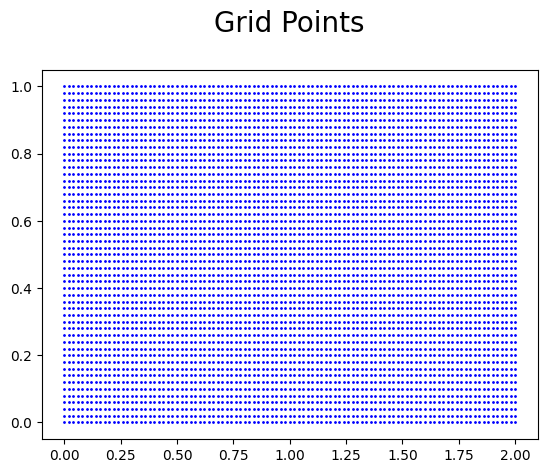

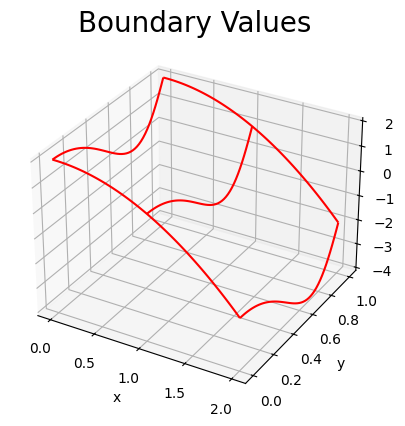

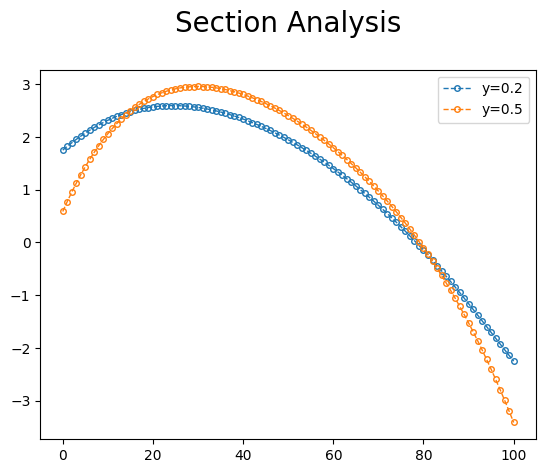

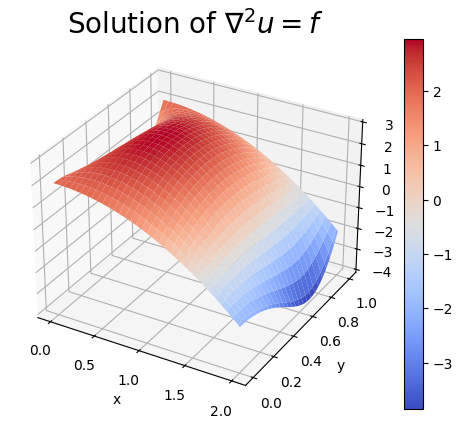

In [4]:
# instantiate
sys=FiniteDifference(
    [0,2],
    [0,1],
    .02
)

# RHS
def f(y):
    """
        for this problem, f = f - laplacian(g)
    """
    yatx = -20 + 3 * y[0]**2 + 4 * y[1]**2 -(-2 - 4*np.pi * np.cos(np.pi * y[1]**2) + 8 * np.pi**2 * y[1]**2 * np.sin(np.pi * y[1]**2))
    return yatx


# bc
def g(y):
    yatx = 2 - y[0]**2 - 2 * np.sin(np.pi * y[1]**2)
    return yatx


# set RHS and bc
sys.RHS=f
sys.BoundaryFunction=g

sys.solve()

sys.show_grid()
sys.show_boundary()
sys.show_section([1,10,25])
sys.show_solution()